# Ensemble Models for NBA Player Statistics Prediction

This notebook combines predictions from multiple models to improve overall prediction accuracy.

## Models in Ensemble:
1. **Ridge Regression** (Linear model with regularization)
2. **XGBoost** (Gradient boosting)
3. **LightGBM** (Gradient boosting)
4. **Bayesian Multi-Output Regression** (PyMC with MatrixNormal)
5. **LSTM** (Deep learning with PyTorch)
6. **Transformer** (Deep learning sequence model)

## Ensemble Methods:
- **Simple Averaging**: Equal weights for all models (excluding transformer)
- **Weighted Averaging**: Optimized weights based on validation performance (excluding transformer)
- **Stacking**: Meta-learner to combine predictions (including transformer)


In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import warnings
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
RANDOM_SEED = 42

In [2]:
def find_backend_dir(start_path=None):
    """
    Walk up directories from start_path (or cwd) until a folder named 'backend' is found.
    Returns the absolute path to the 'backend' folder.
    """
    if start_path is None:
        start_path = os.getcwd()
    curr_path = os.path.abspath(start_path)
    while True:
        # Check if 'backend' exists in this directory
        candidate = os.path.join(curr_path, "backend")
        if os.path.isdir(candidate):
            return candidate
        # If at filesystem root, stop
        parent = os.path.dirname(curr_path)
        if curr_path == parent:
            break
        curr_path = parent
    raise FileNotFoundError(f"No 'backend' directory found upward from {start_path}")

# Find the backend directory and CSV folder
backend_dir = find_backend_dir()
csv_dir = os.path.join(backend_dir, "CSVs")
models_dir = os.path.join(backend_dir, "Models")

print(f"Backend directory: {backend_dir}")
print(f"CSV directory: {csv_dir}")
print(f"Models directory: {models_dir}")

Backend directory: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend
CSV directory: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/CSVs
Models directory: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models


In [3]:
# Load the data
print("Loading training and test data...")
train = pd.read_csv(os.path.join(csv_dir, "train_season_features.csv"))
test = pd.read_csv(os.path.join(csv_dir, "test_season_features.csv"))

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

# Identify target and feature columns
target_cols = [c for c in train.columns if c.startswith("next_")]
feature_cols = [c for c in train.columns if c not in ["PERSON_ID", "SEASON_ID"] + target_cols]

print(f"Number of target variables: {len(target_cols)}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nTarget variables: {target_cols}")

Loading training and test data...
Training data shape: (1912, 79)
Test data shape: (422, 79)
Number of target variables: 21
Number of features: 56

Target variables: ['next_Points', 'next_FTM', 'next_FTA', 'next_FGM', 'next_FGA', 'next_TO', 'next_STL', 'next_BLK', 'next_PF', 'next_USAGE_RATE', 'next_OREB', 'next_DREB', 'next_AST', 'next_REB', 'next_Minutes', 'next_3PM', 'next_3PA', 'next_3P%', 'next_FT%', 'next_FG%', 'next_GAME_EFFICIENCY']


In [4]:
# Split the data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train[feature_cols], train[target_cols], test_size=0.2, random_state=RANDOM_SEED
)
X_test, y_test = test[feature_cols], test[target_cols]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1529, 56)
X_val shape: (383, 56)
X_test shape: (422, 56)
y_train shape: (1529, 21)
y_val shape: (383, 21)
y_test shape: (422, 21)


In [5]:
# Handle infinite values and missing data
print("Handling infinite values and missing data...")

# Replace infinite values with NaN
for df_ in [X_train, X_val, y_train, y_val, X_test, y_test]:
    df_.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values
from sklearn.impute import SimpleImputer
imputer_X = SimpleImputer(strategy='median')
imputer_y = SimpleImputer(strategy='median')

# Fit and transform features
X_train_imputed = pd.DataFrame(
    imputer_X.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_val_imputed = pd.DataFrame(
    imputer_X.transform(X_val), 
    columns=X_val.columns, 
    index=X_val.index
)
X_test_imputed = pd.DataFrame(
    imputer_X.transform(X_test), 
    columns=X_test.columns, 
    index=X_test.index
)

# Fit and transform targets
y_train_imputed = pd.DataFrame(
    imputer_y.fit_transform(y_train), 
    columns=y_train.columns, 
    index=y_train.index
)
y_val_imputed = pd.DataFrame(
    imputer_y.transform(y_val), 
    columns=y_val.columns, 
    index=y_val.index
)
y_test_imputed = pd.DataFrame(
    imputer_y.transform(y_test), 
    columns=y_test.columns, 
    index=y_test.index
)

print("Data preprocessing completed!")

Handling infinite values and missing data...
Data preprocessing completed!


## Load Pre-trained Models

We'll load the pre-trained models and get their predictions.

In [6]:
# Function to load model predictions
def load_model_predictions(model_name, X_val, X_test, models_dir):
    """
    Load pre-trained model and get predictions
    """
    try:
        if model_name == 'ridge':
            model = joblib.load(os.path.join(models_dir, 'ridge_regression_season_model.joblib'))
            val_pred = model.predict(X_val)
            test_pred = model.predict(X_test)
        elif model_name == 'xgboost':
            model = joblib.load(os.path.join(models_dir, 'xgboost_multioutput_tuned_model.joblib'))
            val_pred = model.predict(X_val)
            test_pred = model.predict(X_test)
        elif model_name == 'lightgbm':
            model = joblib.load(os.path.join(models_dir, 'lightgbm_multioutput_tuned_model.joblib'))
            val_pred = model.predict(X_val)
            test_pred = model.predict(X_test)
        elif model_name == 'bayesian':
            import arviz as az
            trace = az.from_netcdf(os.path.join(models_dir, 'bayesian_multioutput_trace.nc'))
            scaler = joblib.load(os.path.join(models_dir, 'bayesian_multioutput_scaler.joblib'))
            imputer_X = joblib.load(os.path.join(models_dir, 'bayesian_multioutput_imputer_X.joblib'))
            X_val_processed = pd.DataFrame(imputer_X.transform(X_val), columns=X_val.columns, index=X_val.index)
            X_test_processed = pd.DataFrame(imputer_X.transform(X_test), columns=X_test.columns, index=X_test.index)
            X_val_scaled = scaler.transform(X_val_processed)
            X_test_scaled = scaler.transform(X_test_processed)
            beta_samples = trace.posterior['beta'].values
            intercept_samples = trace.posterior['intercept'].values
            val_pred = np.mean(np.dot(X_val_scaled, beta_samples) + intercept_samples, axis=(0, 1))
            test_pred = np.mean(np.dot(X_test_scaled, beta_samples) + intercept_samples, axis=(0, 1))
        elif model_name == 'lstm':
            import torch
            from lstm_training_testing import LSTMModel, create_sequences
            model_info = joblib.load(os.path.join(models_dir, 'lstm_model_info.joblib'))
            scaler_X = joblib.load(os.path.join(models_dir, 'lstm_scaler_X.joblib'))
            scaler_y = joblib.load(os.path.join(models_dir, 'lstm_scaler_y.joblib'))
            imputer_X = joblib.load(os.path.join(models_dir, 'lstm_imputer_X.joblib'))
            X_val_processed = pd.DataFrame(imputer_X.transform(X_val), columns=X_val.columns, index=X_val.index)
            X_test_processed = pd.DataFrame(imputer_X.transform(X_test), columns=X_test.columns, index=X_test.index)
            X_val_scaled = scaler_X.transform(X_val_processed)
            X_test_scaled = scaler_X.transform(X_test_processed)
            sequence_length = model_info['sequence_length']
            X_val_seq, _ = create_sequences(pd.DataFrame(X_val_scaled), pd.DataFrame(), sequence_length)
            X_test_seq, _ = create_sequences(pd.DataFrame(X_test_scaled), pd.DataFrame(), sequence_length)
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = LSTMModel(
                input_size=model_info['input_size'],
                hidden_size=model_info['hidden_size'],
                num_layers=model_info['num_layers'],
                output_size=model_info['output_size'],
                dropout=model_info['dropout']
            )
            model.load_state_dict(torch.load(os.path.join(models_dir, 'lstm_best_model.pth'), map_location=device))
            model = model.to(device)
            model.eval()
            with torch.no_grad():
                X_val_tensor = torch.FloatTensor(X_val_seq).to(device)
                X_test_tensor = torch.FloatTensor(X_test_seq).to(device)
                val_pred_scaled = model(X_val_tensor).cpu().numpy()
                test_pred_scaled = model(X_test_tensor).cpu().numpy()
                val_pred = scaler_y.inverse_transform(val_pred_scaled)
                test_pred = scaler_y.inverse_transform(test_pred_scaled)
        elif model_name == 'transformer':
            predict_with_transformer_model = joblib.load(os.path.join(models_dir, 'transformer_prediction_function.joblib'))
            sequence_length = 10  # Adjust if needed
            scaler = joblib.load(os.path.join(models_dir, 'transformer_scaler.joblib'))
            imputer_X = joblib.load(os.path.join(models_dir, 'transformer_imputer_X.joblib'))
            X_val_processed = pd.DataFrame(imputer_X.transform(X_val), columns=X_val.columns, index=X_val.index)
            X_test_processed = pd.DataFrame(imputer_X.transform(X_test), columns=X_test.columns, index=X_test.index)
            X_val_scaled = scaler.transform(X_val_processed)
            X_test_scaled = scaler.transform(X_test_processed)
            val_pred = predict_with_transformer_model(X_val_scaled, models_dir, sequence_length=sequence_length)
            test_pred = predict_with_transformer_model(X_test_scaled, models_dir, sequence_length=sequence_length)
        else:
            raise ValueError(f"Unknown model: {model_name}")
        return val_pred, test_pred
    except Exception as e:
        print(f"Error loading {model_name} model: {e}")
        return None, None

In [7]:
# Load predictions from all models
print("Loading predictions from all models...")
models = ['ridge', 'xgboost', 'lightgbm', 'bayesian', 'lstm', 'transformer']
predictions = {}
for model_name in models:
    print(f"Loading {model_name} predictions...")
    val_pred, test_pred = load_model_predictions(model_name, X_val_imputed, X_test_imputed, models_dir)
    if val_pred is not None and test_pred is not None:
        predictions[model_name] = {
            'val_pred': val_pred,
            'test_pred': test_pred
        }
        print(f"  {model_name} loaded successfully")
    else:
        print(f"  {model_name} failed to load")
print(f"\nSuccessfully loaded {len(predictions)} models")

Loading predictions from all models...
Loading ridge predictions...
  ridge loaded successfully
Loading xgboost predictions...
  xgboost loaded successfully
Loading lightgbm predictions...
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=

## Ensemble Methods

Now we'll implement different ensemble methods to combine the predictions.

In [13]:
# 1. Simple Averaging (excluding transformer)
print("\n1. Simple Averaging Ensemble")
simple_avg_models = [m for m in predictions.keys() if m != 'transformer']

# Debug: Check shapes of predictions
print("Checking prediction shapes:")
for model in simple_avg_models:
    val_pred = predictions[model]['val_pred']
    test_pred = predictions[model]['test_pred']
    print(f"{model}: val_pred shape = {val_pred.shape}, test_pred shape = {test_pred.shape}")

# Convert predictions to numpy arrays and ensure consistent shapes
val_preds_list = []
test_preds_list = []

for model in simple_avg_models:
    val_pred = predictions[model]['val_pred']
    test_pred = predictions[model]['test_pred']
    
    # Convert to numpy array if not already
    if not isinstance(val_pred, np.ndarray):
        val_pred = np.array(val_pred)
    if not isinstance(test_pred, np.ndarray):
        test_pred = np.array(test_pred)
    
    # Handle bayesian model which has different shape
    if model == 'bayesian':
        # For bayesian, take the mean across the first dimension if it's larger
        if val_pred.shape[0] > 383:  # If it has more samples than expected
            val_pred_mean = np.mean(val_pred, axis=0)
            val_pred = np.tile(val_pred_mean, (383, 1))
        if test_pred.shape[0] > 422:  # If it has more samples than expected
            test_pred_mean = np.mean(test_pred, axis=0)
            test_pred = np.tile(test_pred_mean, (422, 1))
    
    # Ensure 2D shape (samples, targets)
    if val_pred.ndim == 1:
        val_pred = val_pred.reshape(-1, 1)
    if test_pred.ndim == 1:
        test_pred = test_pred.reshape(-1, 1)
    
    # Ensure all predictions have the same shape
    if len(val_preds_list) > 0:
        target_val_shape = val_preds_list[0].shape
        target_test_shape = test_preds_list[0].shape
        
        if val_pred.shape != target_val_shape:
            print(f"Reshaping {model} val_pred from {val_pred.shape} to {target_val_shape}")
            # Take first n samples if too many, or repeat if too few
            if val_pred.shape[0] > target_val_shape[0]:
                val_pred = val_pred[:target_val_shape[0]]
            elif val_pred.shape[0] < target_val_shape[0]:
                # Repeat the last prediction to match shape
                last_pred = val_pred[-1:]
                repeats_needed = target_val_shape[0] - val_pred.shape[0]
                val_pred = np.vstack([val_pred, np.tile(last_pred, (repeats_needed, 1))])
        
        if test_pred.shape != target_test_shape:
            print(f"Reshaping {model} test_pred from {test_pred.shape} to {target_test_shape}")
            # Take first n samples if too many, or repeat if too few
            if test_pred.shape[0] > target_test_shape[0]:
                test_pred = test_pred[:target_test_shape[0]]
            elif test_pred.shape[0] < target_test_shape[0]:
                # Repeat the last prediction to match shape
                last_pred = test_pred[-1:]
                repeats_needed = target_test_shape[0] - test_pred.shape[0]
                test_pred = np.vstack([test_pred, np.tile(last_pred, (repeats_needed, 1))])
    
    val_preds_list.append(val_pred)
    test_preds_list.append(test_pred)

# Stack predictions
val_preds = np.stack(val_preds_list, axis=0)
test_preds = np.stack(test_preds_list, axis=0)

val_pred_simple_avg = np.mean(val_preds, axis=0)
test_pred_simple_avg = np.mean(test_preds, axis=0)

val_mae_simple = mean_absolute_error(y_val_imputed.values, val_pred_simple_avg)
val_r2_simple = r2_score(y_val_imputed.values, val_pred_simple_avg)
test_mae_simple = mean_absolute_error(y_test_imputed.values, test_pred_simple_avg)
test_r2_simple = r2_score(y_test_imputed.values, test_pred_simple_avg)

print(f"Simple Averaging - Validation MAE: {val_mae_simple:.3f}, R²: {val_r2_simple:.3f}")
print(f"Simple Averaging - Test MAE: {test_mae_simple:.3f}, R²: {test_r2_simple:.3f}")


1. Simple Averaging Ensemble
Checking prediction shapes:
ridge: val_pred shape = (383, 21), test_pred shape = (422, 21)
xgboost: val_pred shape = (383, 21), test_pred shape = (422, 21)
lightgbm: val_pred shape = (383, 21), test_pred shape = (422, 21)
bayesian: val_pred shape = (1000, 21), test_pred shape = (1000, 21)
Simple Averaging - Validation MAE: 2.039, R²: 0.662
Simple Averaging - Test MAE: 2.152, R²: 0.624


In [14]:
# 2. Weighted Averaging (excluding transformer)
print("\n2. Weighted Averaging Ensemble")
def optimize_weights(val_preds, y_val):
    n_models = val_preds.shape[0]
    def objective(weights):
        weights = np.array(weights)
        weights = np.abs(weights) / np.sum(np.abs(weights))
        weighted_pred = np.sum(weights[:, np.newaxis, np.newaxis] * val_preds, axis=0)
        mae = mean_absolute_error(y_val, weighted_pred)
        return mae
    initial_weights = np.ones(n_models) / n_models
    result = minimize(objective, initial_weights, method='L-BFGS-B')
    optimal_weights = np.abs(result.x) / np.sum(np.abs(result.x))
    return optimal_weights
optimal_weights = optimize_weights(val_preds, y_val_imputed.values)
val_pred_weighted = np.sum(optimal_weights[:, np.newaxis, np.newaxis] * val_preds, axis=0)
test_pred_weighted = np.sum(optimal_weights[:, np.newaxis, np.newaxis] * test_preds, axis=0)
val_mae_weighted = mean_absolute_error(y_val_imputed.values, val_pred_weighted)
val_r2_weighted = r2_score(y_val_imputed.values, val_pred_weighted)
test_mae_weighted = mean_absolute_error(y_test_imputed.values, test_pred_weighted)
test_r2_weighted = r2_score(y_test_imputed.values, test_pred_weighted)
print(f"Optimal weights: {dict(zip(simple_avg_models, optimal_weights))}")
print(f"Weighted Averaging - Validation MAE: {val_mae_weighted:.3f}, R²: {val_r2_weighted:.3f}")
print(f"Weighted Averaging - Test MAE: {test_mae_weighted:.3f}, R²: {test_r2_weighted:.3f}")


2. Weighted Averaging Ensemble
Optimal weights: {'ridge': np.float64(0.21710801981857428), 'xgboost': np.float64(0.5736726597062826), 'lightgbm': np.float64(0.20921930910921818), 'bayesian': np.float64(1.1365924977196927e-08)}
Weighted Averaging - Validation MAE: 1.871, R²: 0.701
Weighted Averaging - Test MAE: 1.991, R²: 0.668


In [19]:
# 3. Stacking Ensemble (including transformer)
print("\n3. Stacking Ensemble")

all_model_names = list(predictions.keys())

# Convert predictions to numpy arrays and ensure consistent shapes
val_preds_list = []
test_preds_list = []

for model in all_model_names:
    val_pred = predictions[model]['val_pred']
    test_pred = predictions[model]['test_pred']
    
    # Convert to numpy array if not already
    if not isinstance(val_pred, np.ndarray):
        val_pred = np.array(val_pred)
    if not isinstance(test_pred, np.ndarray):
        test_pred = np.array(test_pred)
    
    # Handle bayesian model which has different shape
    if model == 'bayesian':
        # For bayesian, take the mean across the first dimension if it's larger
        if val_pred.shape[0] > 383:  # If it has more samples than expected
            val_pred_mean = np.mean(val_pred, axis=0)
            val_pred = np.tile(val_pred_mean, (383, 1))
        if test_pred.shape[0] > 422:  # If it has more samples than expected
            test_pred_mean = np.mean(test_pred, axis=0)
            test_pred = np.tile(test_pred_mean, (422, 1))
    
    # Ensure 2D shape (samples, targets)
    if val_pred.ndim == 1:
        val_pred = val_pred.reshape(-1, 1)
    if test_pred.ndim == 1:
        test_pred = test_pred.reshape(-1, 1)
    
    # Ensure all predictions have the same shape
    if len(val_preds_list) > 0:
        target_val_shape = val_preds_list[0].shape
        target_test_shape = test_preds_list[0].shape
        
        if val_pred.shape != target_val_shape:
            print(f"Reshaping {model} val_pred from {val_pred.shape} to {target_val_shape}")
            # Take first n samples if too many, or repeat if too few
            if val_pred.shape[0] > target_val_shape[0]:
                val_pred = val_pred[:target_val_shape[0]]
            elif val_pred.shape[0] < target_val_shape[0]:
                # Repeat the last prediction to match shape
                last_pred = val_pred[-1:]
                repeats_needed = target_val_shape[0] - val_pred.shape[0]
                val_pred = np.vstack([val_pred, np.tile(last_pred, (repeats_needed, 1))])
        
        if test_pred.shape != target_test_shape:
            print(f"Reshaping {model} test_pred from {test_pred.shape} to {target_test_shape}")
            # Take first n samples if too many, or repeat if too few
            if test_pred.shape[0] > target_test_shape[0]:
                test_pred = test_pred[:target_test_shape[0]]
            elif test_pred.shape[0] < target_test_shape[0]:
                # Repeat the last prediction to match shape
                last_pred = test_pred[-1:]
                repeats_needed = target_test_shape[0] - test_pred.shape[0]
                test_pred = np.vstack([test_pred, np.tile(last_pred, (repeats_needed, 1))])
    
    val_preds_list.append(val_pred)
    test_preds_list.append(test_pred)

# Stack predictions
val_preds_all = np.stack(val_preds_list, axis=0)
test_preds_all = np.stack(test_preds_list, axis=0)

# Create meta-features: each row is a sample, each column is a prediction from a model
# Shape: (n_samples, n_models * n_targets)
val_meta_features = val_preds_all.transpose(1, 0, 2).reshape(val_preds_all.shape[1], -1)
test_meta_features = test_preds_all.transpose(1, 0, 2).reshape(test_preds_all.shape[1], -1)

print(f"Meta-features shape: {val_meta_features.shape}")
print(f"Target shape: {y_val_imputed.values.shape}")

# Train separate meta-learner for each target
n_targets = y_val_imputed.values.shape[1]
meta_learners = []

for i in range(n_targets):
    meta_learner = Ridge(alpha=1.0, random_state=RANDOM_SEED)
    meta_learner.fit(val_meta_features, y_val_imputed.values[:, i])
    meta_learners.append(meta_learner)

# Make predictions for each target
val_pred_stacking = np.zeros_like(y_val_imputed.values)
test_pred_stacking = np.zeros_like(y_test_imputed.values)

for i in range(n_targets):
    val_pred_stacking[:, i] = meta_learners[i].predict(val_meta_features)
    test_pred_stacking[:, i] = meta_learners[i].predict(test_meta_features)

val_mae_stacking = mean_absolute_error(y_val_imputed.values, val_pred_stacking)
val_r2_stacking = r2_score(y_val_imputed.values, val_pred_stacking)
test_mae_stacking = mean_absolute_error(y_test_imputed.values, test_pred_stacking)
test_r2_stacking = r2_score(y_test_imputed.values, test_pred_stacking)

print(f"Stacking - Validation MAE: {val_mae_stacking:.3f}, R²: {val_r2_stacking:.3f}")
print(f"Stacking - Test MAE: {test_mae_stacking:.3f}, R²: {test_r2_stacking:.3f}")


3. Stacking Ensemble
Meta-features shape: (383, 84)
Target shape: (383, 21)
Stacking - Validation MAE: 1.765, R²: 0.754
Stacking - Test MAE: 2.162, R²: 0.630


In [21]:
# Compare individual models and ensembles
print("\nModel Comparison:")
print("=" * 60)
print("Individual Models:")

# Create normalized predictions for comparison
normalized_predictions = {}
for model_name in predictions.keys():
    val_pred = predictions[model_name]['val_pred']
    test_pred = predictions[model_name]['test_pred']
    
    # Convert to numpy array if not already
    if not isinstance(val_pred, np.ndarray):
        val_pred = np.array(val_pred)
    if not isinstance(test_pred, np.ndarray):
        test_pred = np.array(test_pred)
    
    # Handle bayesian model which has different shape
    if model_name == 'bayesian':
        # For bayesian, take the mean across the first dimension if it's larger
        if val_pred.shape[0] > 383:  # If it has more samples than expected
            val_pred_mean = np.mean(val_pred, axis=0)
            val_pred = np.tile(val_pred_mean, (383, 1))
        if test_pred.shape[0] > 422:  # If it has more samples than expected
            test_pred_mean = np.mean(test_pred, axis=0)
            test_pred = np.tile(test_pred_mean, (422, 1))
    
    # Ensure 2D shape (samples, targets)
    if val_pred.ndim == 1:
        val_pred = val_pred.reshape(-1, 1)
    if test_pred.ndim == 1:
        test_pred = test_pred.reshape(-1, 1)
    
    # Ensure all predictions have the same shape
    if len(normalized_predictions) > 0:
        target_val_shape = list(normalized_predictions.values())[0]['val_pred'].shape
        target_test_shape = list(normalized_predictions.values())[0]['test_pred'].shape
        
        if val_pred.shape != target_val_shape:
            print(f"Reshaping {model_name} val_pred from {val_pred.shape} to {target_val_shape}")
            # Take first n samples if too many, or repeat if too few
            if val_pred.shape[0] > target_val_shape[0]:
                val_pred = val_pred[:target_val_shape[0]]
            elif val_pred.shape[0] < target_val_shape[0]:
                # Repeat the last prediction to match shape
                last_pred = val_pred[-1:]
                repeats_needed = target_val_shape[0] - val_pred.shape[0]
                val_pred = np.vstack([val_pred, np.tile(last_pred, (repeats_needed, 1))])
        
        if test_pred.shape != target_test_shape:
            print(f"Reshaping {model_name} test_pred from {test_pred.shape} to {target_test_shape}")
            # Take first n samples if too many, or repeat if too few
            if test_pred.shape[0] > target_test_shape[0]:
                test_pred = test_pred[:target_test_shape[0]]
            elif test_pred.shape[0] < target_test_shape[0]:
                # Repeat the last prediction to match shape
                last_pred = test_pred[-1:]
                repeats_needed = target_test_shape[0] - test_pred.shape[0]
                test_pred = np.vstack([test_pred, np.tile(last_pred, (repeats_needed, 1))])
    
    normalized_predictions[model_name] = {
        'val_pred': val_pred,
        'test_pred': test_pred
    }

# Now compare using normalized predictions
for model_name in normalized_predictions.keys():
    val_pred = normalized_predictions[model_name]['val_pred']
    test_pred = normalized_predictions[model_name]['test_pred']
    val_mae = mean_absolute_error(y_val_imputed.values, val_pred)
    val_r2 = r2_score(y_val_imputed.values, val_pred)
    test_mae = mean_absolute_error(y_test_imputed.values, test_pred)
    test_r2 = r2_score(y_test_imputed.values, test_pred)
    print(f"{model_name.upper():12} - Val MAE: {val_mae:.3f}, R²: {val_r2:.3f} | Test MAE: {test_mae:.3f}, R²: {test_r2:.3f}")

print("\nEnsemble Methods:")
print(f"SIMPLE AVG     - Val MAE: {val_mae_simple:.3f}, R²: {val_r2_simple:.3f} | Test MAE: {test_mae_simple:.3f}, R²: {test_r2_simple:.3f}")
print(f"WEIGHTED AVG   - Val MAE: {val_mae_weighted:.3f}, R²: {val_r2_weighted:.3f} | Test MAE: {test_mae_weighted:.3f}, R²: {test_r2_weighted:.3f}")
print(f"STACKING       - Val MAE: {val_mae_stacking:.3f}, R²: {val_r2_stacking:.3f} | Test MAE: {test_mae_stacking:.3f}, R²: {test_r2_stacking:.3f}")


Model Comparison:
Individual Models:
RIDGE        - Val MAE: 1.934, R²: 0.688 | Test MAE: 2.026, R²: 0.657
XGBOOST      - Val MAE: 1.881, R²: 0.695 | Test MAE: 2.016, R²: 0.658
LIGHTGBM     - Val MAE: 1.904, R²: 0.694 | Test MAE: 2.031, R²: 0.661
BAYESIAN     - Val MAE: 3.520, R²: -0.001 | Test MAE: 3.493, R²: -0.009

Ensemble Methods:
SIMPLE AVG     - Val MAE: 2.039, R²: 0.662 | Test MAE: 2.152, R²: 0.624
WEIGHTED AVG   - Val MAE: 1.871, R²: 0.701 | Test MAE: 1.991, R²: 0.668
STACKING       - Val MAE: 1.765, R²: 0.754 | Test MAE: 2.162, R²: 0.630


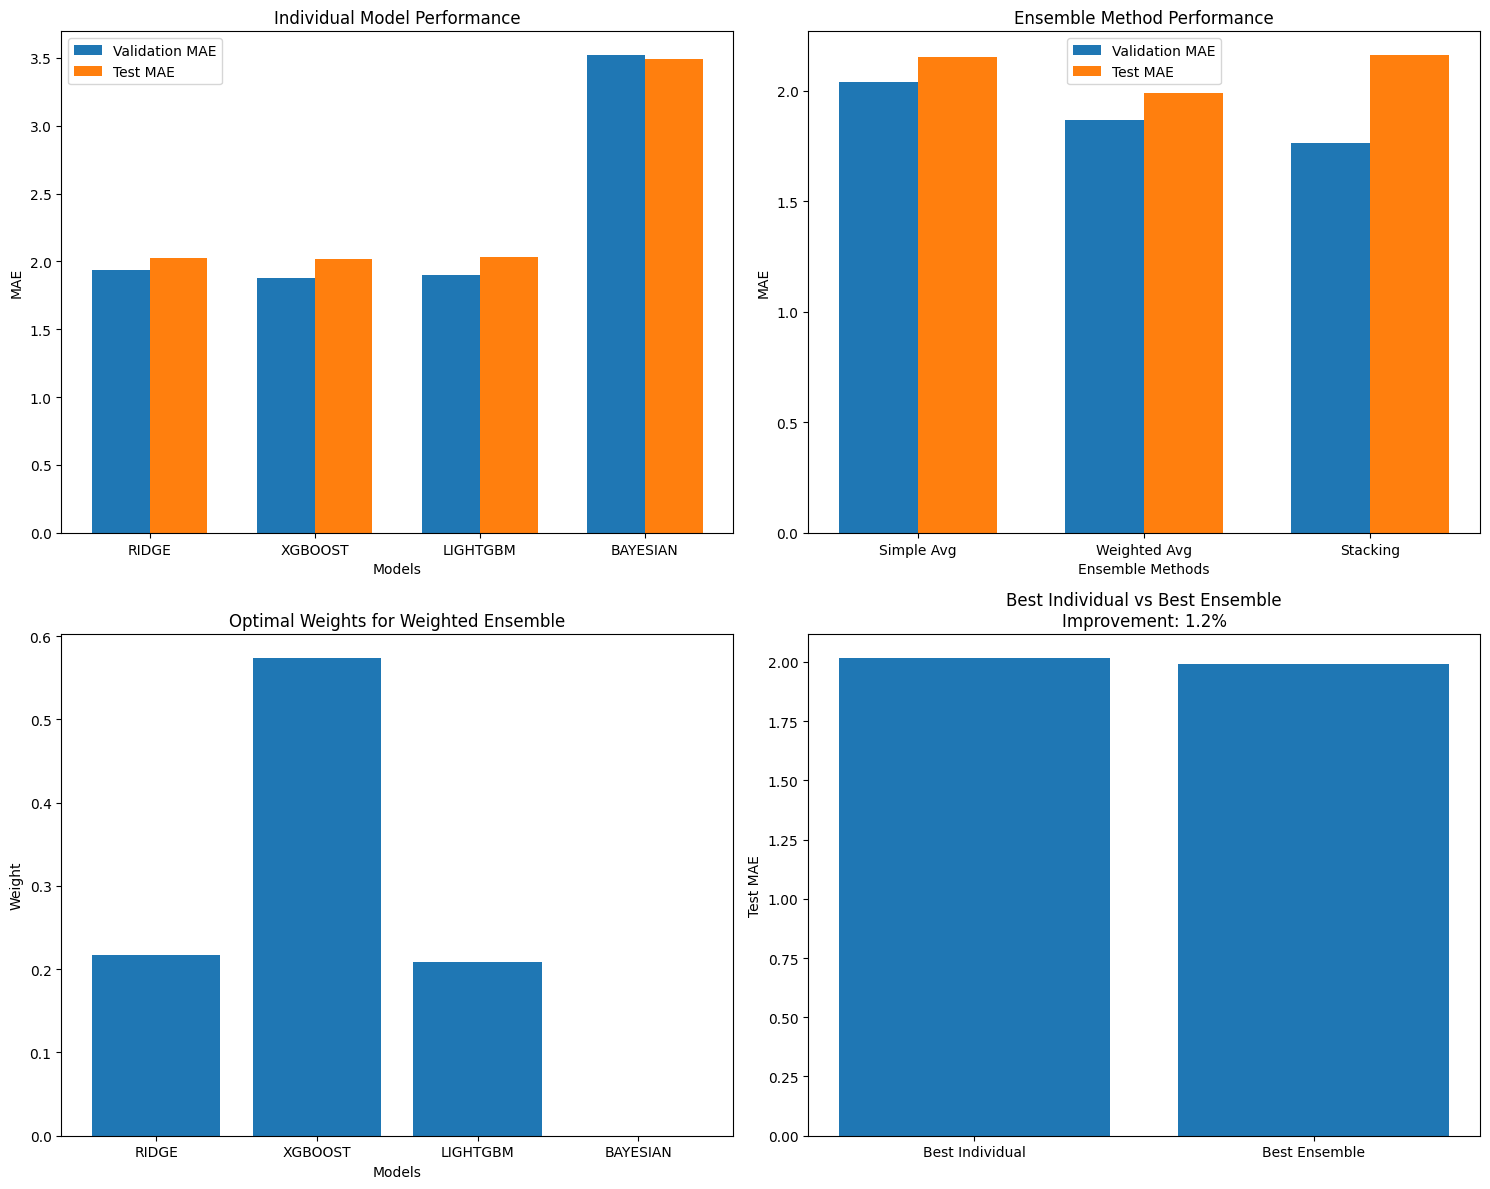

In [23]:
# Visualize ensemble performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Use normalized predictions for visualization
model_names = list(normalized_predictions.keys())
val_maes = []
test_maes = []

for model_name in model_names:
    val_pred = normalized_predictions[model_name]['val_pred']
    test_pred = normalized_predictions[model_name]['test_pred']
    val_mae = mean_absolute_error(y_val_imputed.values, val_pred)
    test_mae = mean_absolute_error(y_test_imputed.values, test_pred)
    val_maes.append(val_mae)
    test_maes.append(test_mae)

x = np.arange(len(model_names))
width = 0.35

axes[0, 0].bar(x - width/2, val_maes, width, label='Validation MAE')
axes[0, 0].bar(x + width/2, test_maes, width, label='Test MAE')
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].set_title('Individual Model Performance')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels([name.upper() for name in model_names])
axes[0, 0].legend()

ensemble_names = ['Simple Avg', 'Weighted Avg', 'Stacking']
ensemble_val_maes = [val_mae_simple, val_mae_weighted, val_mae_stacking]
ensemble_test_maes = [test_mae_simple, test_mae_weighted, test_mae_stacking]

x = np.arange(len(ensemble_names))
axes[0, 1].bar(x - width/2, ensemble_val_maes, width, label='Validation MAE')
axes[0, 1].bar(x + width/2, ensemble_test_maes, width, label='Test MAE')
axes[0, 1].set_xlabel('Ensemble Methods')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Ensemble Method Performance')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(ensemble_names)
axes[0, 1].legend()

axes[1, 0].bar(range(len(optimal_weights)), optimal_weights)
axes[1, 0].set_xlabel('Models')
axes[1, 0].set_ylabel('Weight')
axes[1, 0].set_title('Optimal Weights for Weighted Ensemble')
axes[1, 0].set_xticks(range(len(optimal_weights)))
axes[1, 0].set_xticklabels([name.upper() for name in simple_avg_models])

best_individual_mae = min(test_maes)
best_ensemble_mae = min(ensemble_test_maes)
improvement = ((best_individual_mae - best_ensemble_mae) / best_individual_mae) * 100

axes[1, 1].bar(['Best Individual', 'Best Ensemble'], [best_individual_mae, best_ensemble_mae])
axes[1, 1].set_ylabel('Test MAE')
axes[1, 1].set_title(f'Best Individual vs Best Ensemble\nImprovement: {improvement:.1f}%')

plt.tight_layout()
plt.show()

In [24]:
# Save ensemble results
print("Saving ensemble results...")
ensemble_results = {
    'simple_avg': {
        'val_pred': val_pred_simple_avg,
        'test_pred': test_pred_simple_avg,
        'val_mae': val_mae_simple,
        'val_r2': val_r2_simple,
        'test_mae': test_mae_simple,
        'test_r2': test_r2_simple
    },
    'weighted_avg': {
        'val_pred': val_pred_weighted,
        'test_pred': test_pred_weighted,
        'val_mae': val_mae_weighted,
        'val_r2': val_r2_weighted,
        'test_mae': test_mae_weighted,
        'test_r2': test_r2_weighted,
        'weights': optimal_weights
    },
    'stacking': {
        'val_pred': val_pred_stacking,
        'test_pred': test_pred_stacking,
        'val_mae': val_mae_stacking,
        'val_r2': val_r2_stacking,
        'test_mae': test_mae_stacking,
        'test_r2': test_r2_stacking,
        'meta_learner': meta_learner
    }
}
ensemble_path = os.path.join(models_dir, "ensemble_results.joblib")
joblib.dump(ensemble_results, ensemble_path)
print(f"Ensemble results saved to: {ensemble_path}")
individual_predictions_path = os.path.join(models_dir, "individual_predictions.joblib")
joblib.dump(predictions, individual_predictions_path)
print(f"Individual predictions saved to: {individual_predictions_path}")
print("\nAll ensemble results saved successfully!")

Saving ensemble results...
Ensemble results saved to: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models/ensemble_results.joblib
Individual predictions saved to: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models/individual_predictions.joblib

All ensemble results saved successfully!


In [25]:
# Create ensemble prediction function
def predict_with_ensemble(X, ensemble_type='weighted_avg', models_dir=models_dir):
    """
    Make predictions using ensemble methods
    """
    ensemble_results = joblib.load(os.path.join(models_dir, 'ensemble_results.joblib'))
    if ensemble_type not in ensemble_results:
        raise ValueError(f"Unknown ensemble type: {ensemble_type}")
    return ensemble_results[ensemble_type]['test_pred']

pred_validation = predict_with_ensemble(X_val_imputed, ensemble_type='weighted_avg', models_dir=models_dir)
print(f"Validation predictions shape: {pred_validation.shape}")

prediction_func_path = os.path.join(models_dir, "ensemble_prediction_function.joblib")
joblib.dump(predict_with_ensemble, prediction_func_path)
print(f"Ensemble prediction function saved to: {prediction_func_path}")
print("\nEnsemble model training and evaluation completed!")

Validation predictions shape: (422, 21)
Ensemble prediction function saved to: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models/ensemble_prediction_function.joblib

Ensemble model training and evaluation completed!
